# The 2016 Cold Springs Fire destroyed 8 homes and burned hundreds of acres
### The fire burned outside of Nederland in Boulder County, CO 
#### @millie-spencer October 2023

![The 2016 Cold Springs Fire](https://www.denverpost.com/wp-content/uploads/2016/07/001_fire.jpg?w=810)
> Image source: The Denver Post https://www.denverpost.com/wp-content/uploads/2016/07/001_fire.jpg?w=810

## This project uses Normalized Difference Vegetation Index (NDVI) to assess vegetation recovery post-wildfire


In [1]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Make project directory with path to datasource
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'coldsprings-fire')
os.makedirs(project_dir, exist_ok=True)
project_dir

'/home/jovyan/earth-analytics/data/coldsprings-fire'

In [3]:
# reading geodataframe
coldsprings_gdf = gpd.read_file(
"https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
"Historic_Geomac_Perimeters_2016/FeatureServer/0/query?where=latest%"
"20%3D%20%27Y%27%20AND%20state%20%3D%20%27CO%27%20AND%20incidentname%"
"20%3D%20%27COLD%20SPRINGS%27&outFields=*&outSR=4326&f=json")

coldsprings_gdf

,OBJECTID,agency,comments,active,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,...,state,inciwebid,localincidentidentifier,irwinid,incomplex,complexfirecode,latest,shape__Area,shape__Length,geometry
0,1003,C&L,,N,Unknown,1468540800000,2016-COBLX-000457,2016,Cold Springs,COBLX,...,CO,4848,000457,221c1b99-d2fe-4abe-9ef1-31225b812dcd,N,,Y,3.640322e+06,14922.590938,"MULTIPOLYGON (((-105.48912 39.98666, -105.4888..."


In [4]:
# Draw fire subdivision boundaries
# Cold Springs fire location 
coldsprings_lat = 39.9810
coldsprings_lon = -105.4803

#create a folium map object
m = folium.Map(location=[coldsprings_lat, coldsprings_lon], 
               zoom_start=15, scrollWheelZoom=False)

# Convert the GeoDataFrame to GeoJSON format 
coldsprings_geojson = coldsprings_gdf.to_json()

#add the GeoJSON data to the map as a GeoJson layer 
folium.GeoJson(coldsprings_geojson).add_to(m)

# Add a location marker 
folium.Marker(location=[coldsprings_lat, coldsprings_lon]).add_to(m)

# Display the map inline
m

## Vegetation Analysis 
This analysis utilizes Normalized Difference Vegetation Index (NDVI) data in Red and Near-Infrared (NIR) spectra to assess vegetation recovery post-wildfire. This data is collected by the MODIS sensor on NASA's Aqua satellite, and can be accessed from NASA's APPEEARS API: https://appeears.earthdatacloud.nasa.gov/. 

In [5]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi',
    ea_dir=project_dir,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2015, 2020],
    polygon=coldsprings_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

In [6]:
# Produce file names and select NDVI files
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

ndvi_path_list

['/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2016201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2015201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2019137_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2018185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2017169_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244/MYD13Q1.061__250m_16_days_NDVI_doy2020185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/coldsprings-fire/modis-ndvi/MYD13Q1.061_2015137_to_2020244

In [7]:
# identify what place in the string the data characters start/end
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor 

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 6, x: 20)>
 array([[[0.6087, 0.6323, 0.5813, 0.5813, 0.5775, 0.5775, 0.6306, 0.4595,
          0.5607, 0.5607, 0.6125, 0.5979, 0.5693, 0.5693, 0.5437, 0.5984,
          0.7088, 0.7088, 0.7088, 0.6808],
         [0.596 , 0.5404, 0.4238, 0.4238, 0.4238, 0.2817, 0.3347, 0.4595,
          0.4595, 0.3429, 0.4748, 0.6028, 0.6028, 0.6116, 0.6116, 0.6273,
          0.5896, 0.5896, 0.5896, 0.5505],
         [0.596 , 0.4267, 0.3703, 0.3703, 0.3703, 0.4828, 0.3533, 0.3533,
          0.2967, 0.5564, 0.5859, 0.588 , 0.588 , 0.6235, 0.6235, 0.5341,
          0.5341, 0.6067, 0.6067, 0.6261],
         [0.6056, 0.5349, 0.5349, 0.3199, 0.3812, 0.3812, 0.4386, 0.4386,
          0.5098, 0.4155, 0.4298, 0.4298, 0.3333, 0.2945, 0.2945, 0.2945,
          0.4524, 0.3972, 0.3972, 0.3972],
         [0.6309, 0.6309, 0.6309, 0.4675, 0.4541, 0.4541, 0.4541, 0.4782,
          0.3986, 0.4155, 0.4155, 0.4459, 0.346 , 0.2696, 0.2696, 0.2696,
          0.2657, 0.2961, 0.4929, 0.49

In [8]:
#stack arrays by date into a timeseries 
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 20, y: 6, date: 40)
Coordinates:
    band         int64 1
  * x            (x) float64 -105.5 -105.5 -105.5 ... -105.5 -105.5 -105.5
  * y            (y) float64 39.99 39.98 39.98 39.98 39.98 39.98
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2015-05-17 2015-06-02 ... 2020-08-20
Data variables:
    NDVI         (date, y, x) float32 0.5777 0.5777 0.6125 ... 0.4966 0.6005

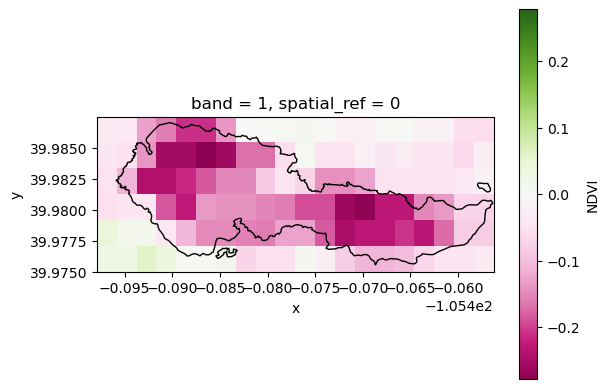

In [9]:
# Plot change in NDVI spatially
import matplotlib.pyplot as plt
import earthpy.plot as ep 
from rasterio.plot import plotting_extent

# Code from ChatGBT: calculate change in NDVI pre- and -post fire 
# 1. Select data from 2017 using the .sel() method
data_2017 = ndvi_ds.sel(date='2017')

# 2. Take the temporal mean (over the date, not spatially) using the .mean() method
mean_2017 = data_2017.mean(dim='date')

# 3. Repeat for the data from 2015
data_2015 = ndvi_ds.sel(date='2015')
mean_2015 = data_2015.mean(dim='date')

# 4. Subtract the pre-fire year (2017) from the post-fire years (2019)
difference = mean_2017 - mean_2015
ndvi_plot_extent = plotting_extent(difference.to_array(), 
    difference.to_array().rio.transform())

# 5. Plot the result - issue with hvplot so trying earthpy
dndvi_da = (ndvi_ds
    .sel(date='2017')
    .mean('date')
    .NDVI
- ndvi_ds
    .sel(date='2015')
    .mean('date')
    .NDVI
)
dndvi_da.plot(cmap=plt.colormaps['PiYG'])
# add fire boundary (coldsprings_gdf)
coldsprings_gdf.plot(facecolor='none', ax=plt.gca())
plt.show()

In [10]:
# Create envelope - get the area outside of the fire perimeter
out_gdf = (
    gpd.GeoDataFrame(geometry=coldsprings_gdf.envelope)
    .overlay(coldsprings_gdf, how='difference')
)
out_gdf

,geometry
0,"MULTIPOLYGON (((-105.49589 39.97558, -105.4958..."


In [11]:
# Clip DataArray to the boundaries in and out of fire boundary 
ndvi_fire_ds = ndvi_ds.rio.clip(coldsprings_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [12]:
# Chaining Xarray methods
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])
ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

ndvi_fire_df, ndvi_out_df

(          NDVI
 year          
 2015  0.638246
 2016  0.480340
 2017  0.467333
 2018  0.467369
 2019  0.480110
 2020  0.448641,
           NDVI
 year          
 2015  0.641087
 2016  0.580334
 2017  0.597027
 2018  0.572842
 2019  0.577915
 2020  0.571362)

<Axes: xlabel='year'>

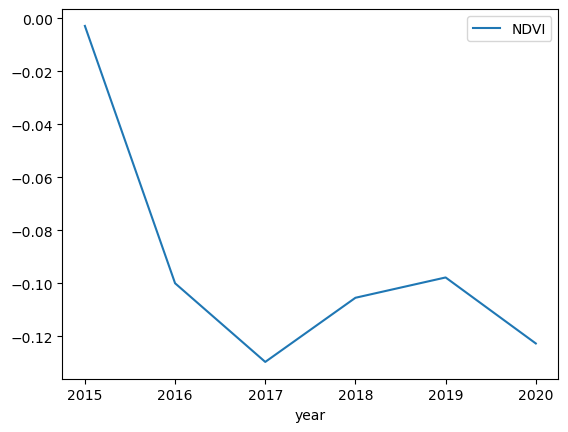

In [13]:
# Plot change in NDVI post and pre fire
(ndvi_fire_df - ndvi_out_df).plot()

## Peak green NDVI dropped by approximately 0.13 inside the boundary immediately post-fire. 
Vegetation Index continued declining after the 2016 fire, hitting a low-point in 2017. Although NDVI increased slightly in 2018 and again in 2019, vegetation declined once again in 2020 perhaps due to land development. Upon further analysis of Google Earth imagery, it is unclear why the NDVI increased and then dropped again, as the landscape looks visually quite similar over the course of 2016-2020, with no apparent vegetation regrowth post-fire. 

In [14]:
%%capture
%%bash
jupyter nbconvert coldsprings-fire-modis-ndvi.ipynb --to html --no-input